# Preprocessing for Final Dataset
## Set up environment

In [2]:
import os
import pandas as pd
import numpy as np
import statistics
import re
from fuzzywuzzy import process, fuzz

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the stop words
stop_words = set(stopwords.words('english'))

# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import OrdinalEncoder

c:\Users\Justin\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Justin\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Justin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Justin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Justin\AppData\Roaming\nltk_data...


KeyboardInterrupt: 

## Pull in required data:

In [ ]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

os.listdir(path + 'raw/')

['BX-NewBooksUsers.csv',
 'BX-Books.csv',
 'BX-Ratings.csv',
 'BX-Users.csv',
 'BX-NewBooksRatings.csv',
 'BX-NewBooks.csv']

In [ ]:
books = pd.read_csv(path + 'cleaned/BX-Books.csv')
users = pd.read_csv(path + 'cleaned/BX-Users.csv')
ratings = pd.read_csv(path + 'cleaned/BX-Ratings.csv')

In [ ]:
books.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,0002005018,clara callan,richard bruce wright,2001.0,harperflamingo canada,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8


In [ ]:
ratings.head(1)

,User-ID,ISBN,Book-Rating
0,276744,038550120X,7


In [ ]:
users.head(1)

,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,User-Country-Encoded,Age-Group-Encoded
0,8,timmins,ontario,canada,20.0,"(4, 24]",17,0


## Discretize book ratings

array([[<Axes: title={'center': 'Book-Rating'}>]], dtype=object)

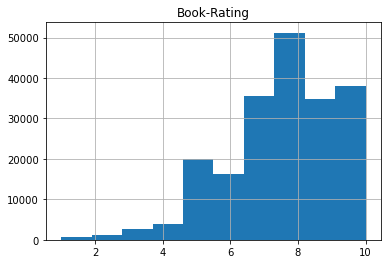

In [ ]:
# ratings are skewed towards higher
# users are more likely to leave a nice review
ratings.hist('Book-Rating')

#### Create feature that states the popularity of a book:
Since some books have more reviews this will be taken into consideration for popularity. While also taking in the average rating of a book

In [ ]:
df = ratings.merge(users)

In [ ]:
df

,User-ID,ISBN,Book-Rating,User-City,User-State,User-Country,User-Age,Age-Group,User-Country-Encoded,Age-Group-Encoded
0,276744,038550120X,7,torrance,california,usa,17.0,"(4, 24]",124,0
1,276754,0684867621,8,alberta beach,alberta,canada,19.0,"(4, 24]",17,0
2,276755,0451166892,5,frankfurt am main,hessen,germany,32.0,"(24, 35]",41,1
3,276762,0380711524,5,duisburg,unknown,germany,25.0,"(24, 35]",41,1
4,276772,0553572369,7,bonn,unknown,germany,28.0,"(24, 35]",41,1
...,...,...,...,...,...,...,...,...,...,...
203958,276688,0892966548,10,fort lee,new jersey,usa,64.0,"(50, 100]",124,3
203959,276688,1551669315,6,fort lee,new jersey,usa,64.0,"(50, 100]",124,3
203960,276704,0345386108,6,cedar park,texas,usa,33.0,"(24, 35]",124,1
203961,276704,0743211383,7,cedar park,texas,usa,33.0,"(24, 35]",124,1


In [ ]:
weighted_ratings = df.groupby(['ISBN', 'User-Country', 'User-Country-Encoded', 'Age-Group-Encoded', 'Age-Group']).agg(average_rating 
                                     = ('Book-Rating', 'mean'), times_read = ('User-ID', 'count'), average_age = ('User-Age', 'mean')) \
                                    .reset_index()

In [ ]:
weighted_ratings

,ISBN,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age
0,0002005018,canada,17,0,"(4, 24]",7.333333,3,20.000000
1,0002005018,canada,17,1,"(24, 35]",7.666667,3,27.666667
2,0002005018,canada,17,3,"(50, 100]",7.000000,1,60.000000
3,0002005018,unknown,121,3,"(50, 100]",8.000000,1,63.000000
4,0002116286,canada,17,1,"(24, 35]",7.000000,2,32.000000
...,...,...,...,...,...,...,...,...
86701,9871138148,germany,41,1,"(24, 35]",9.000000,1,33.000000
86702,9871138148,portugal,89,2,"(35, 50]",9.000000,1,41.000000
86703,9871138148,spain,102,0,"(4, 24]",10.000000,1,15.000000
86704,9871138148,spain,102,1,"(24, 35]",6.000000,1,25.000000


In [ ]:
read_books = weighted_ratings.groupby('ISBN')['times_read'].sum()

books_over = read_books[read_books > 10].index

In [ ]:
weighted_ratings = weighted_ratings[weighted_ratings['ISBN'].isin(books_over)]

In [ ]:
m = 3
# weighted_ratings = weighted_ratings[weighted_ratings['times_read'] > m]
weighted_ratings

,ISBN,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age
80,000649840X,australia,7,1,"(24, 35]",9.000000,1,32.000000
81,000649840X,australia,7,2,"(35, 50]",8.000000,1,39.000000
82,000649840X,canada,17,1,"(24, 35]",3.000000,1,30.000000
83,000649840X,canada,17,2,"(35, 50]",7.000000,1,37.000000
84,000649840X,hong kong,46,1,"(24, 35]",10.000000,1,34.000000
...,...,...,...,...,...,...,...,...
86593,8845205118,italy,55,2,"(35, 50]",7.000000,2,41.500000
86594,8845205118,unknown,121,1,"(24, 35]",9.000000,2,28.500000
86615,884590184X,italy,55,0,"(4, 24]",7.285714,7,20.571429
86616,884590184X,italy,55,1,"(24, 35]",8.000000,7,29.571429


In [ ]:
t = weighted_ratings['times_read']
a = weighted_ratings['average_rating']
c = ratings[ratings['ISBN'].isin(books_over)]['Book-Rating'].mean()

In [ ]:
weighted_ratings['weighted_ratings'] = ((t*a/(t+m))) + ((m*c/(m+t)))

/var/folders/z5/2xfh619x3csdbh0bph8vb9100000gn/T/ipykernel_48860/1790009516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_ratings['weighted_ratings'] = ((t*a/(t+m))) + ((m*c/(m+t)))


In [ ]:
weighted_ratings

,ISBN,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings
80,000649840X,australia,7,1,"(24, 35]",9.000000,1,32.000000,8.075719
81,000649840X,australia,7,2,"(35, 50]",8.000000,1,39.000000,7.825719
82,000649840X,canada,17,1,"(24, 35]",3.000000,1,30.000000,6.575719
83,000649840X,canada,17,2,"(35, 50]",7.000000,1,37.000000,7.575719
84,000649840X,hong kong,46,1,"(24, 35]",10.000000,1,34.000000,8.325719
...,...,...,...,...,...,...,...,...,...
86593,8845205118,italy,55,2,"(35, 50]",7.000000,2,41.500000,7.460575
86594,8845205118,unknown,121,1,"(24, 35]",9.000000,2,28.500000,8.260575
86615,884590184X,italy,55,0,"(4, 24]",7.285714,7,20.571429,7.430288
86616,884590184X,italy,55,1,"(24, 35]",8.000000,7,29.571429,7.930288


array([[<Axes: title={'center': 'weighted_ratings'}>]], dtype=object)

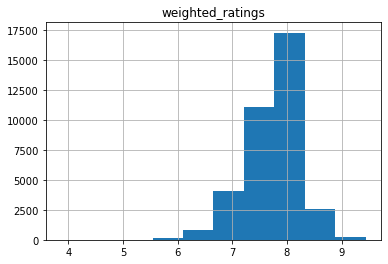

In [ ]:
weighted_ratings.hist('weighted_ratings')

In [ ]:
df = books.merge(weighted_ratings)

In [ ]:
df.shape

(36196, 17)

In [ ]:
df.sort_values('weighted_ratings', ascending = False).head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings
13874,0439139597,harry potter goblet fire book 4,j k rowling,2000.0,scholastic,harry potter goblet fire book 4 by j k rowling,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,1,"(24, 35]",9.588235,34,30.058824,9.440618
13873,0439139597,harry potter goblet fire book 4,j k rowling,2000.0,scholastic,harry potter goblet fire book 4 by j k rowling,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,0,"(4, 24]",9.552632,38,18.342105,9.422021
11579,0345339738,return king lord ring part 3,j r r tolkien,1986.0,del rey,return king lord ring part 3 by j r r tolkien,[0. 0. 0. ... 0. 0. 0.],"(1979, 1989]",6,usa,124,1,"(24, 35]",9.586207,29,29.034483,9.415715
2977,0345339711,two tower lord ring part 2,j r r tolkien,1986.0,del rey,two tower lord ring part 2 by j r r tolkien,[0. 0. 0. ... 0. 0. 0.],"(1979, 1989]",6,usa,124,1,"(24, 35]",9.571429,28,28.928571,9.396867
36021,0439425220,harry potter chamber secret postcard book,j k rowling,2002.0,scholastic,harry potter chamber secret postcard book by j...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,1,"(24, 35]",10.000000,8,30.375000,9.391171


## Labelling weighted ratings:

array([[<Axes: title={'center': 'weighted_ratings'}>]], dtype=object)

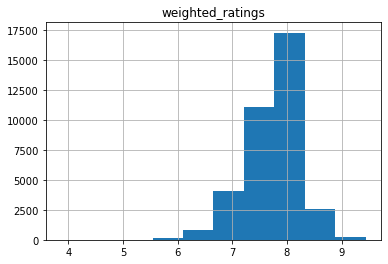

In [ ]:
weighted_ratings.hist('weighted_ratings')

In [ ]:
ratings_to_list = ratings['Book-Rating'].to_list

std_dev = statistics.stdev(ratings_to_list)
mean = statistics.mean(ratings_to_list)

bin_2 = mean - std_dev
bin_4 = mean + std_dev

ratings_list = [0,bin_2,mean,bin_4,10]


NameError: name 'ratings' is not defined

In [ ]:
df['weighted_ratings_group'] = pd.cut(x=df['weighted_ratings'], bins=ratings_list)

In [ ]:
encoder = OrdinalEncoder()
encoded_w_ratings = encoder.fit_transform(df[['weighted_ratings_group']])
df[['weighted_ratings_group_encoded']] = encoded_w_ratings.astype(int)

In [ ]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group,weighted_ratings_group_encoded
0,0399135782,kitchen god wife,amy tan,1991.0,putnam pub group,kitchen god wife by amy tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,malaysia,65,0,"(4, 24]",10.0,1,21.0,8.325719,"(8.0, 8.5]",3


In [ ]:
df.groupby(['weighted_ratings_group'])['ISBN'].count()

/var/folders/z5/2xfh619x3csdbh0bph8vb9100000gn/T/ipykernel_48860/2350359258.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['weighted_ratings_group'])['ISBN'].count()


weighted_ratings_group
(0.0, 7.0]      2215
(7.0, 7.7]     12974
(7.7, 8.0]      8162
(8.0, 8.5]     11460
(8.5, 10.0]     1385
Name: ISBN, dtype: int64

In [ ]:
df.groupby(['weighted_ratings_group_encoded'])['ISBN'].count()

weighted_ratings_group_encoded
0     2215
1    12974
2     8162
3    11460
4     1385
Name: ISBN, dtype: int64

In [ ]:
df.to_csv(path + 'processed/processed_books.csv', index = False)